<a href="https://colab.research.google.com/github/LinaTobon/Proyecticos-/blob/main/AnalysisMarketingCampaign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data analysis marketing Campaign

### ¿What is the company about? 
They sell products from 5 major categories: wines, rare meat products, exotic fruits, specially prepared fish and sweet products. These can further be divided into gold and regular products. The customers can order and acquire products through 3 sales channels: physical stores, catalogs and company’s website.

### Strategy

*   develop a model that predicts customer behavior and to apply it to the rest of the customer base. the model will allow the company to cherry pick the customers that are most likely to purchase the offer while leaving out the non-respondents, making the next campaign highly profitable.
*   understanding to study the characteristic features of those customers who are willing to buy the gadget.


que caracteristicas?
que edad tienen?
que nivel de ingresos y estudios?
cuantos hijos?
por donde compran?
que compran?
cada cuanto compran?
cuanto tiempo llevan comprando con nosotros?
han tenido malas experiencias en su compra?

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
from scipy.stats import iqr
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")

In [ ]:
# importing dataset
campaign_data = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/PruebaIfood/ml_project1_data.csv',index_col='ID')

In [ ]:
# Visualizing some rows of the dataset
campaign_data.head(5)

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5524,1957,Graduation,Single,58138.00,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
2174,1954,Graduation,Single,46344.00,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
4141,1965,Graduation,Together,71613.00,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
6182,1984,Graduation,Together,26646.00,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
5324,1981,PhD,Married,58293.00,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [ ]:
# Getting column information
campaign_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2240 entries, 5524 to 9405
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year_Birth           2240 non-null   int64  
 1   Education            2240 non-null   object 
 2   Marital_Status       2240 non-null   object 
 3   Income               2216 non-null   float64
 4   Kidhome              2240 non-null   int64  
 5   Teenhome             2240 non-null   int64  
 6   Dt_Customer          2240 non-null   object 
 7   Recency              2240 non-null   int64  
 8   MntWines             2240 non-null   int64  
 9   MntFruits            2240 non-null   int64  
 10  MntMeatProducts      2240 non-null   int64  
 11  MntFishProducts      2240 non-null   int64  
 12  MntSweetProducts     2240 non-null   int64  
 13  MntGoldProds         2240 non-null   int64  
 14  NumDealsPurchases    2240 non-null   int64  
 15  NumWebPurchases      2240 non-null 

Conclusions

*   We have 2240 registers and 26 features, apparently there is just one  feature (income) that have null values (24 rows).


*   The feature DT_Customer and Year_Birth need to be formated to timestamp

* We have 8 categorical features than can be segregated as follows:


> **categorical nominal features**
*   Marital_Status.   
*   AcceptedCmp3  
*   AcceptedCmp4
*   AcceptedCmp5 
*   AcceptedCmp1
*   AcceptedCmp2
*   Complain
*   Response

> **categorical ordinal features**
*   Education

# Data Cleansing

In [ ]:
# Formatting the Dt_Customer as a datetime column
campaign_data['Dt_Customer_formated'] = pd.to_datetime(campaign_data['Dt_Customer'])
# Replacing strange levels of marital Status that are associated with the level single
campaign_data.Marital_Status.replace(['YOLO','Absurd','Alone'],'Single',inplace=True)

# Feature engineering

In [ ]:

# lets compute the age of the sample
campaign_data['Age'] = 2021 - campaign_data['Year_Birth'] 
# lets get the numbers of childs per customer
campaign_data['Childs'] = campaign_data['Kidhome']+ campaign_data['Teenhome']
#How many years the customer has been buying with us?
campaign_data['Fidelity'] = 2021 - campaign_data['Dt_Customer_formated'].dt.year
#How many campaigns has the customer accepted?
AcceptedCmp_col = [col for col in campaign_data.columns if col.startswith('AcceptedCmp')]
campaign_data['AcceptedCmp'] = campaign_data[AcceptedCmp_col].sum(axis=1)

In [ ]:
# lets get some age groups from the age column
rangos= [0,27,40,52,72,150]
groups = ['GenZ','GenY','GenX','BabyBoom','Gen_Silent']
campaign_data['AgeGroup'] = pd.cut(campaign_data['Age'], bins=rangos, labels=groups, right=False)

In [ ]:
# z_revenue and z_CostContact are constants so they dont have variance or predicting power, so wi will drop them
features = [col for col in campaign_data.columns if col not in ('Dt_Customer','Year_Birth','Z_CostContact','Z_Revenue')]
col2levels = [col for col in features if (list(pd.unique(campaign_data[col]))==[1,0] or list(pd.unique(campaign_data[col]))==[0,1])]

# replacing (yes/ no) in binary variables
for col in col2levels:
  campaign_data[col] = campaign_data[col].replace(0,'No').replace(1,'Yes')

# diviving features into categorical and numerical variables
categorical_features = [col for col in features if campaign_data.dtypes[col]==np.object and col!="Response"]
numerical_features = [col for col in features if campaign_data.dtypes[col]==np.int64 or campaign_data.dtypes[col]==np.float64 and col!="Response"]



In [ ]:
multi_var = [i for i in categorical_features if i not in col2levels] + ['AgeGroup']

In [ ]:
categorical_features

['Education',
 'Marital_Status',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'Complain']

In [ ]:
numerical_features

['Income',
 'Kidhome',
 'Teenhome',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'Age',
 'Childs',
 'Fidelity',
 'AcceptedCmp']

# Exploratory Data Analysis

## Univariate analysis


### Numerical variables

In [ ]:
# getting some basical statistics abour our numerical features
pd.set_option('display.float_format', lambda x: '%.2f' % x)
campaign_data[numerical_features].describe().T

,count,mean,std,min,25%,50%,75%,max
Income,2216.00,52247.25,25173.08,1730.00,35303.00,51381.50,68522.00,666666.00
Kidhome,2240.00,0.44,0.54,0.00,0.00,0.00,1.00,2.00
Teenhome,2240.00,0.51,0.54,0.00,0.00,0.00,1.00,2.00
Recency,2240.00,49.11,28.96,0.00,24.00,49.00,74.00,99.00
MntWines,2240.00,303.94,336.60,0.00,23.75,173.50,504.25,1493.00
MntFruits,2240.00,26.30,39.77,0.00,1.00,8.00,33.00,199.00
MntMeatProducts,2240.00,166.95,225.72,0.00,16.00,67.00,232.00,1725.00
MntFishProducts,2240.00,37.53,54.63,0.00,3.00,12.00,50.00,259.00
MntSweetProducts,2240.00,27.06,41.28,0.00,1.00,8.00,33.00,263.00
MntGoldProds,2240.00,44.02,52.17,0.00,9.00,24.00,56.00,362.00


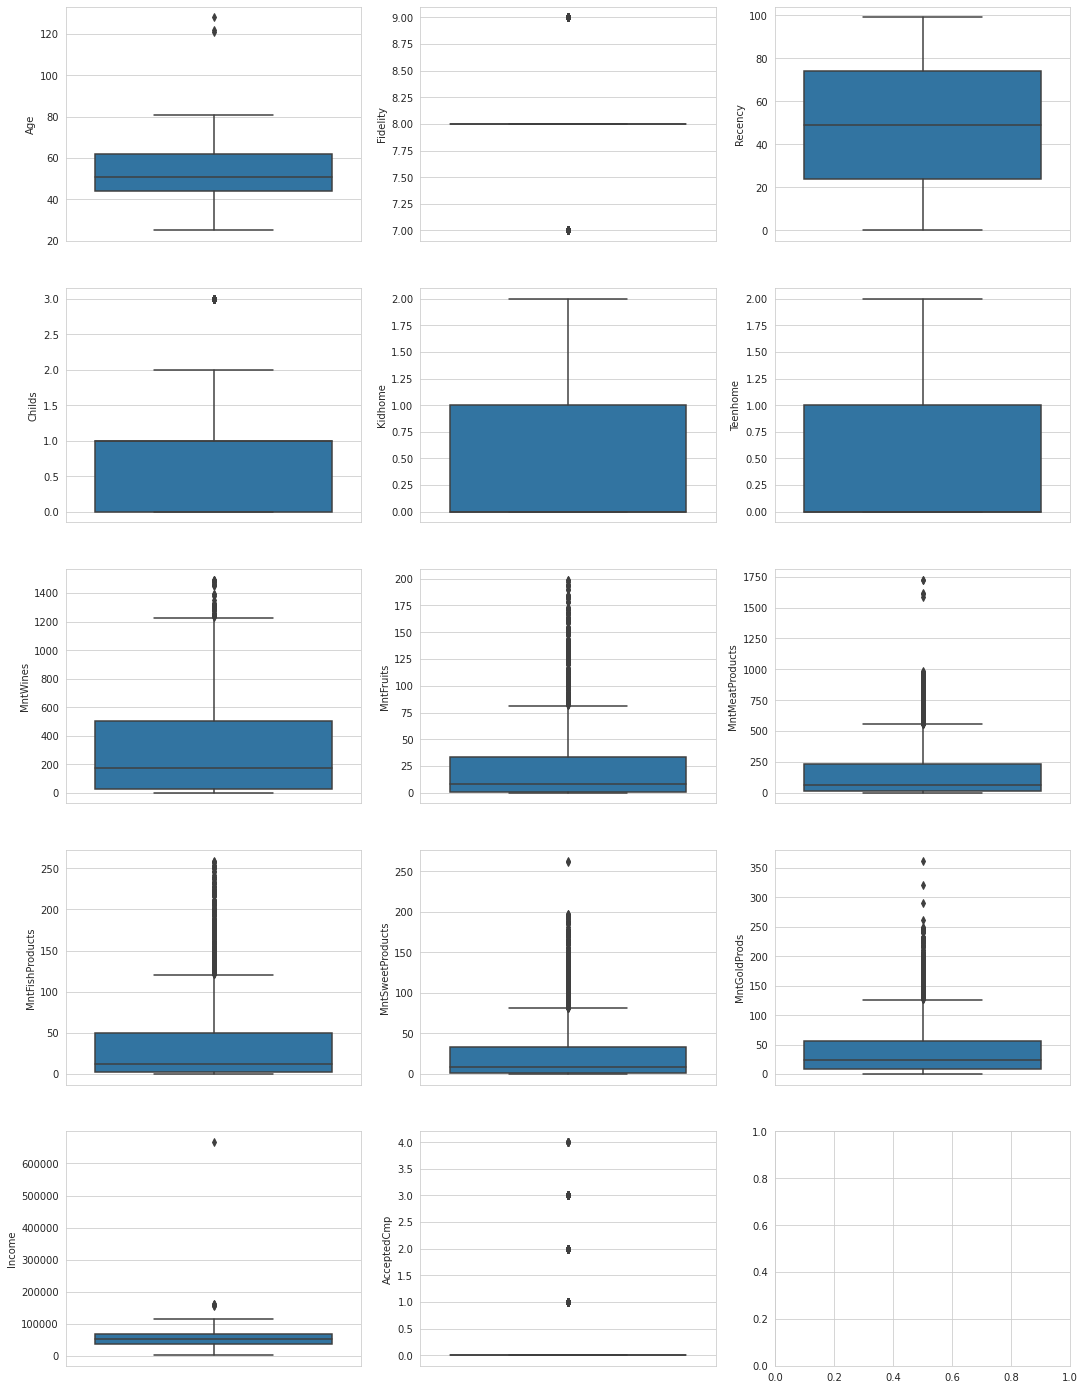

In [ ]:

fig, axes = plt.subplots(5, 3, figsize=(18, 25))
sns.boxplot(ax=axes[0, 0], data=campaign_data, y='Age')
sns.boxplot(ax=axes[0, 1], data=campaign_data, y='Fidelity')
sns.boxplot(ax=axes[0, 2], data=campaign_data, y='Recency')
sns.boxplot(ax=axes[1, 0], data=campaign_data, y='Childs')
sns.boxplot(ax=axes[1, 1], data=campaign_data, y='Kidhome')
sns.boxplot(ax=axes[1, 2], data=campaign_data, y='Teenhome')
sns.boxplot(ax=axes[2, 0], data=campaign_data, y='MntWines')
sns.boxplot(ax=axes[2, 1], data=campaign_data, y='MntFruits')
sns.boxplot(ax=axes[2, 2], data=campaign_data, y='MntMeatProducts')
sns.boxplot(ax=axes[3, 0], data=campaign_data, y='MntFishProducts')
sns.boxplot(ax=axes[3, 1], data=campaign_data, y='MntSweetProducts')
sns.boxplot(ax=axes[3, 2], data=campaign_data, y='MntGoldProds')
sns.boxplot(ax=axes[4, 0], data=campaign_data, y='Income')
sns.boxplot(ax=axes[4, 1], data=campaign_data, y='AcceptedCmp')

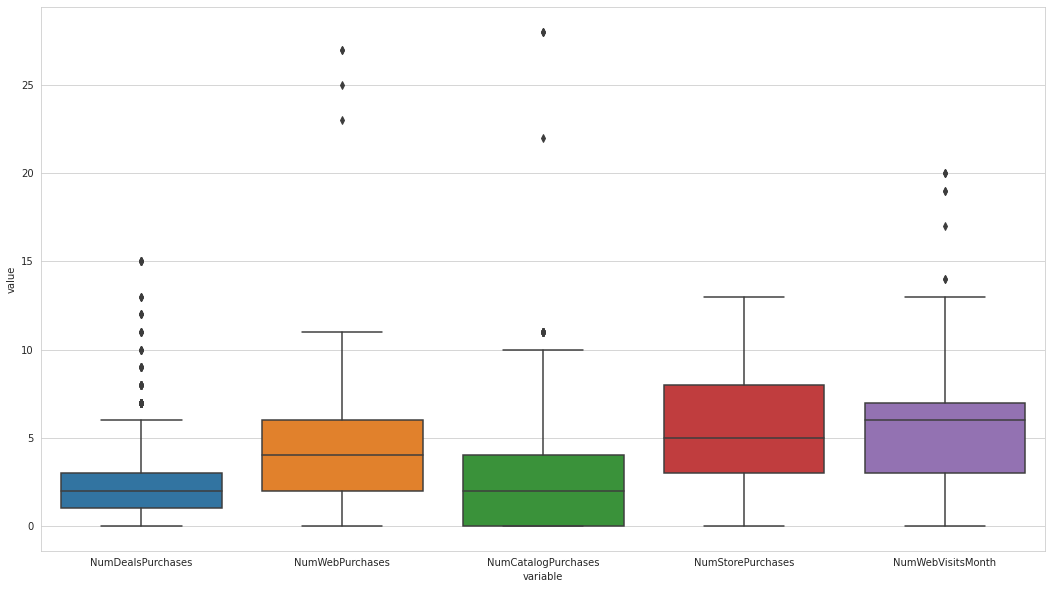

In [ ]:
fig= plt.subplots(figsize=(18, 10))
sns.boxplot(x="variable", y="value", data=pd.melt(campaign_data[['NumDealsPurchases', 'NumWebPurchases','NumCatalogPurchases','NumStorePurchases','NumWebVisitsMonth']]))

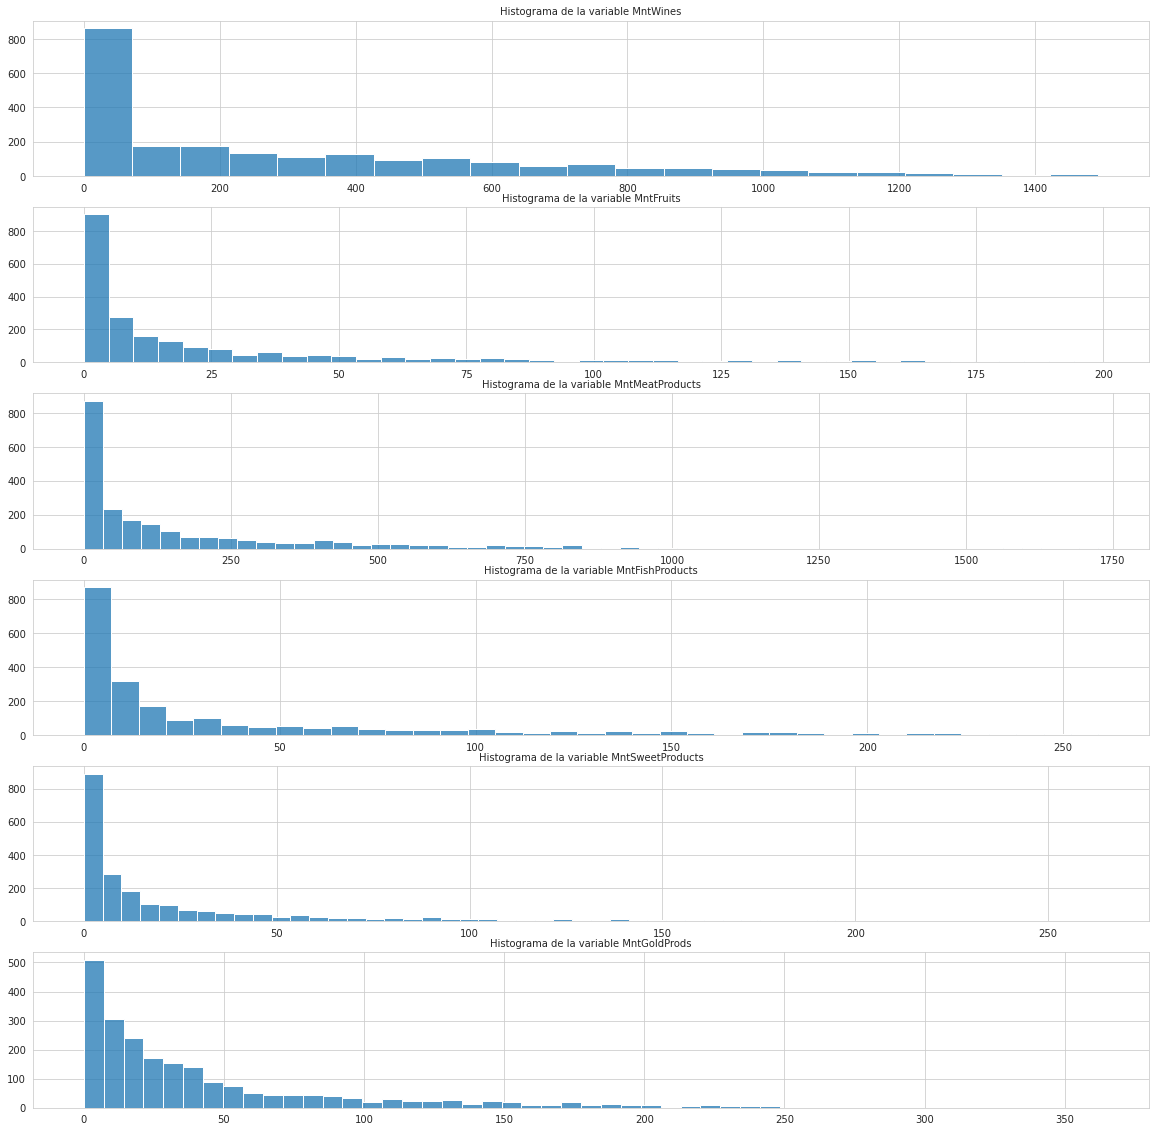

In [ ]:
# lets see in detail the distribution of the variables related to amounts of productos
Mnt_col = [col for col in campaign_data.columns if col.startswith('Mnt')]
(figure, ax) = plt.subplots(nrows = len(Mnt_col), ncols=1, figsize=(20,20))
ax = ax.flatten()
sns.set_style("whitegrid")
for i in range(len(Mnt_col)):
    sns.histplot(campaign_data[Mnt_col[i]], ax= ax[i])
    ax[i].set_title('Histograma de la variable '+ Mnt_col[i], fontsize = 10)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('');

Observaciones
*  AGE:   
La variable age sugiere una distribución aproximandamente normal, además presenta dos puntos atípicos que deberán ser estudiados con mas detalle para identificar la mejor manera de tratarlos. Los participantes del piloto son en general personas maduras, pues el promedio de edad es de 51 años y el 25% más joven de la muestra tiene una edad entre 25 y 44 años.

* FIDELITY:   
Los participantes del piloto son clientes antiguos de la compañía pues llevan entre 7 y 9 años comprando con nosotros.

*  RECENCY:  
 La variable recency sugiere una distribución aproximandamente normal. Ademàs evidencia que los participantes en el piloto llevan en promedio más de un mes sin comprar con la compañía, este comportamiento debe ser analizado a mayor produndidad con información histórica para poder definir si es una tendencia frecuente dentro de los clientes.

*  CHILDS:   
Las familias que hacen parte del piloto son familias pequeñas, pues El 75% de los participantes en el piloto no tienen hijos o tienen a lo sumo un hijo.El número máximo de hijos es 3.

* INCOME: la variable income presenta una distribución asimétrica positiva, lo que nos indica que existe mayor concentración de los datos alrededor de ingresos bajos. Además, presenta 2 valores atípicos que deberán ser analizados para definir cómo se tratarán.

* MntWines - MntFruits - MntMeatProducts - MntFishProducts - MntSweetProducts: Las características asociadas a los montos de productos comprados por los clientes presentan un gran número de observaciones atípicas en los boxplots,sugiriendo una distribución asimétrica positiva. Al analizar sus distribuciones estas variables sugieren una distribución exponencial.

* NumWebPurchases - NumStorePurchases - NumCatalogPurchases:  
El canal de compra predilecto de los participantes del piloto son las compras en la tienda (NumStorePurchases), seguido por las compras en página web y por catálogo.


In [ ]:
# function that will help us to aggregate and obtain the percentage of each level for the categorical variables
def aggregation_feature(feature):
  globals()['df' + str(feature)] = pd.pivot_table(campaign_data, index=[feature], 
                       values=['Response'], aggfunc={'Response': 'count'})
  globals()['df' + str(feature)].rename(columns={'Response':'Count'},inplace=True)
  globals()['df' + str(feature)].reset_index(inplace=True)
  globals()['df' + str(feature)]['Perc'] = round((globals()['df' + str(feature)]['Count']/globals()['df' + str(feature)]['Count'].sum())*100,2)
  return globals()['df' + str(feature)]

for i in categorical_features:
  aggregation_feature(i)

In [ ]:
# acceptation rate per campaign

dfCampaigns = pd.DataFrame(round(campaign_data[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']].replace('No',0).replace('Yes',1).mean()*100,2), 
                           columns=['Perc']).reset_index()

# plot
fig=px.bar(dfCampaigns, x='Perc', y="index",title='What is the most successful campaign?',orientation='h',text='Perc')
fig.update_layout(barmode='stack', yaxis={'categoryorder':'total ascending'})
fig.show()

**Los porcentajes de eficacia de las últimas campañas en términos de causar la acción de compra en los clientes, presentan valores inferiores al 8%, siendo la campaña más exitosa la cuatro.**


In [ ]:
fig = px.pie(dfComplain, values='Perc', names='Complain', title='Have they had a bad experience with us?')
fig.show()

**La anterior gráfica muestra un nivel alto en la calidad del servicio de la compañía, pues menos del 1% de los participantes del piloto ha presentado quejas respecto al servicio ofrecido.**

In [ ]:
px.histogram(campaign_data, x='Response', barmode='group',title='How many clients accepted the new campaign?')

In [ ]:
aggregation_feature('AgeGroup')
fig = px.pie(dfAgeGroup, values='Perc', names='AgeGroup', title='What is the age of our respondents?')
fig.show()

**Los participantes del piloto son personas maduras, pues la mayoría de los participantes del piloto son babyboomers, seguidos por la generación x y la generación y. Tienen una baja participación en el piloto la generación z y la silent generación.**

In [ ]:
fig = px.pie(dfMarital_Status, values='Perc', names='Marital_Status', title='What is the marital status of our respondents?')
fig.show()

In [ ]:
dfMntTotal = campaign_data[Mnt_col]
dfMntTotal['TotalMnt']= campaign_data[Mnt_col].sum(axis=1)
for i in Mnt_col:
  dfMntTotal['perc' + str(i)]= dfMntTotal[i].div(dfMntTotal['TotalMnt'], axis=0)*100

perc_col = [col for col in dfMntTotal.columns if col.startswith('perc')]

summary= pd.DataFrame(dfMntTotal[perc_col].mean(),columns=['perc']).reset_index()
fig = px.pie(summary, values='perc',names='index',title='What is the mean percent of money clients spent in each product?')
fig.show()


**Los participantes gastan mas en vinos, pues  Los vinos son la categroría de productos con el mayor promedio de participación en el consumo. Seguido por productos cárnicos y productos de la categoría gold.**

# Multivariate Data analysis

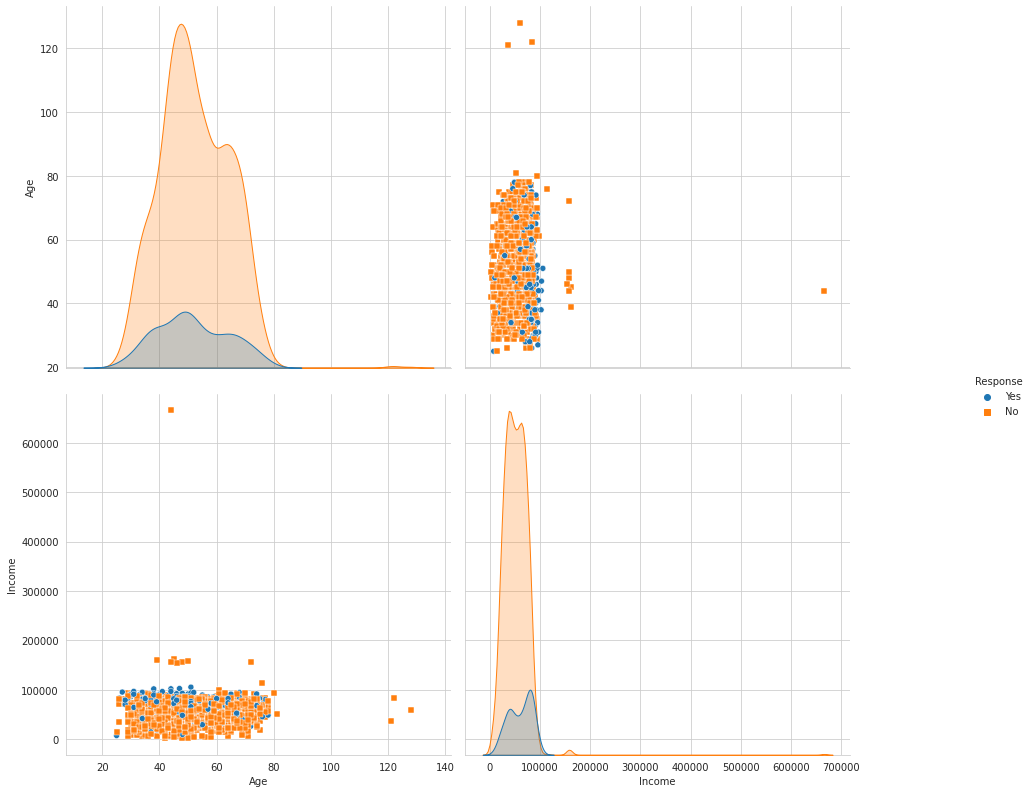

In [ ]:
g = sns.pairplot(data=campaign_data, hue='Response',vars=['Age','Income'],  markers=["o", "s"])
g.fig.set_size_inches(16,12)

Entonces ... ¿Quiénes son nuestros clientes?

We have a varied range of Customers in this store. People with income as high as 700k yearly income and some customers with less than $100k yearly income as well.

However, majority of customers are with low yearly income and there are only a few which have income more than $100k. This means that the store caters to majorly low-income group customers and doesn't entertain rich/luxury customers.

So, we will remove this outliers otherwise it will pose a problem in further analysis. We use the log transformation technqiue for this.

# Data Cleaning

### Outliers treatment:

from the analysis and graphs above, we have seen that the variables Income and Age have otliers. We are going to check the best way to impute them.

#### Age

In [ ]:
# the oldest person alive is 112 years old, so we will drop all rows with an age greater than 112
campaign_data.drop(campaign_data[campaign_data['Age']>112].index,inplace=True)

#### Income
We will drop extreme ouliers, wich are values greater or lower tha  3 times the IQR.

### Missing values:

from the analysis and graphs above, we have seen that the variables Income and Age have otliers. We are going to check the best way to impute them.

In [ ]:
# income has an extreme outlier that we will remove
campaign_data.drop(campaign_data[campaign_data['Income']>iqr(campaign_data['Income'])*3].index,inplace=True)
campaign_data.drop(campaign_data[campaign_data['Income']<iqr(campaign_data['Income'])*3].index,inplace=True)

In [ ]:
# how does the income change per  education level
fig = px.box(campaign_data, x='Education', y='Income', points="all",title='Income vs Education level')
fig.update_yaxes(range=[0, 200000])
fig.show()


In [ ]:
# imputing null values in income  with the median income per education level and age
campaign_data['Income'] = campaign_data.groupby(['Education','AgeGroup'])['Income'].transform(lambda x: x.fillna(x.median()))

# Prepocessing

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline, make_union, FeatureUnion, Pipeline
from sklearn.utils.multiclass import unique_labels

### Feature scaling

In [ ]:
scaler = MinMaxScaler()
# transform data
campaign_data[numerical_features] = scaler.fit_transform(campaign_data[numerical_features])

### Encoding

In [ ]:
campaign_data[numerical_features]

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Childs,Fidelity,AcceptedCmp
ID,,,,,,,,,,,,,,,,,,,
5524,0.08,0.00,0.00,0.59,0.43,0.44,0.32,0.66,0.33,0.24,0.20,0.30,0.36,0.31,0.35,0.70,0.00,1.00,0.00
2174,0.07,0.50,0.50,0.38,0.01,0.01,0.00,0.01,0.00,0.02,0.13,0.04,0.04,0.15,0.25,0.75,0.67,0.00,0.00
4141,0.11,0.00,0.00,0.26,0.29,0.25,0.07,0.43,0.08,0.12,0.07,0.30,0.07,0.77,0.20,0.55,0.00,0.50,0.00
6182,0.04,0.50,0.00,0.26,0.01,0.02,0.01,0.04,0.01,0.01,0.13,0.07,0.00,0.31,0.30,0.21,0.33,0.00,0.00
5324,0.09,0.50,0.00,0.95,0.12,0.22,0.07,0.18,0.10,0.04,0.33,0.19,0.11,0.46,0.25,0.27,0.33,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10870,0.09,0.00,0.50,0.46,0.47,0.22,0.11,0.16,0.45,0.68,0.13,0.33,0.11,0.31,0.25,0.52,0.33,0.50,0.00
4001,0.09,1.00,0.50,0.57,0.27,0.00,0.02,0.00,0.00,0.02,0.47,0.30,0.07,0.38,0.35,0.89,1.00,0.00,0.25
7270,0.08,0.00,0.00,0.92,0.61,0.24,0.13,0.12,0.05,0.07,0.07,0.07,0.11,1.00,0.30,0.27,0.00,0.00,0.25


In [ ]:
campaign_data_enc = campaign_data.copy()
campaign_data_enc.drop(columns=['Year_Birth','Dt_Customer','Z_CostContact','Z_Revenue','Dt_Customer_formated'],inplace=True)

In [ ]:
col2levels.remove('Response')

In [ ]:
# Codificación para variables binarias
for i in  col2levels:
    campaign_data_enc[i] = LabelEncoder().fit_transform(campaign_data_enc[i])

In [ ]:
# Codificación de variables dummies para variables categoricas con más de 2 clases

for i in multi_var:
    campaign_data_enc[i] = campaign_data_enc[i].astype('category')

campaign_data_enc = pd.get_dummies(campaign_data_enc, columns=multi_var)

In [ ]:
# Codificación de la variable respuesta
campaign_data_enc['Response'] = LabelEncoder().fit_transform(campaign_data_enc['Response'])

In [ ]:
campaign_data_enc

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Childs,Fidelity,AcceptedCmp,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,AgeGroup_GenZ,AgeGroup_GenY,AgeGroup_GenX,AgeGroup_BabyBoom,AgeGroup_Gen_Silent
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5524,0.08,0.00,0.00,0.59,0.43,0.44,0.32,0.66,0.33,0.24,0.20,0.30,0.36,0.31,0.35,0,0,0,0,0,0,1,0.70,0.00,1.00,0.00,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
2174,0.07,0.50,0.50,0.38,0.01,0.01,0.00,0.01,0.00,0.02,0.13,0.04,0.04,0.15,0.25,0,0,0,0,0,0,0,0.75,0.67,0.00,0.00,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
4141,0.11,0.00,0.00,0.26,0.29,0.25,0.07,0.43,0.08,0.12,0.07,0.30,0.07,0.77,0.20,0,0,0,0,0,0,0,0.55,0.00,0.50,0.00,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
6182,0.04,0.50,0.00,0.26,0.01,0.02,0.01,0.04,0.01,0.01,0.13,0.07,0.00,0.31,0.30,0,0,0,0,0,0,0,0.21,0.33,0.00,0.00,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
5324,0.09,0.50,0.00,0.95,0.12,0.22,0.07,0.18,0.10,0.04,0.33,0.19,0.11,0.46,0.25,0,0,0,0,0,0,0,0.27,0.33,0.00,0.00,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10870,0.09,0.00,0.50,0.46,0.47,0.22,0.11,0.16,0.45,0.68,0.13,0.33,0.11,0.31,0.25,0,0,0,0,0,0,0,0.52,0.33,0.50,0.00,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
4001,0.09,1.00,0.50,0.57,0.27,0.00,0.02,0.00,0.00,0.02,0.47,0.30,0.07,0.38,0.35,0,0,0,1,0,0,0,0.89,1.00,0.00,0.25,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
7270,0.08,0.00,0.00,0.92,0.61,0.24,0.13,0.12,0.05,0.07,0.07,0.07,0.11,1.00,0.30,0,1,0,0,0,0,0,0.27,0.00,0.00,0.25,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0


## Features importance

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from yellowbrick.features import RFECV
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [ ]:
chi2_best_var = SelectKBest(chi2,
                            k= len(campaign_data_enc.drop(columns = ['Response']).columns)
                           ).fit(campaign_data_enc.drop(columns = ['Response']),campaign_data_enc['Response'])

In [ ]:
pd.DataFrame({'var':campaign_data_enc.drop(columns = ['Response']).columns,'scores':chi2_best_var.scores_, 'p_value':chi2_best_var.pvalues_}).sort_values('scores', ascending=False)

,var,scores,p_value
17,AcceptedCmp5,223.48,0.00
18,AcceptedCmp1,180.77,0.00
24,AcceptedCmp,157.10,0.00
15,AcceptedCmp3,133.96,0.00
16,AcceptedCmp4,64.77,0.00
19,AcceptedCmp2,63.22,0.00
4,MntWines,34.16,0.00
6,MntMeatProducts,22.14,0.00
32,Marital_Status_Single,21.51,0.00
23,Fidelity,15.74,0.00


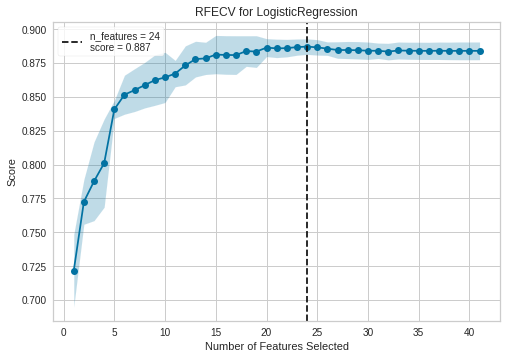

In [ ]:
viz = RFECV(LogisticRegression(), cv=3, scoring='roc_auc')
viz.fit(campaign_data_enc.drop(columns = 'Response'),campaign_data_enc['Response'])
viz.poof()

In [ ]:
pd.DataFrame({'var':campaign_data_enc.drop(columns = 'Response').columns, 
              'rank':viz.ranking_}).sort_values(by ='rank')

,var,rank
17,AcceptedCmp5,1
24,AcceptedCmp,1
23,Fidelity,1
22,Childs,1
21,Age,1
19,AcceptedCmp2,1
18,AcceptedCmp1,1
16,AcceptedCmp4,1
15,AcceptedCmp3,1
14,NumWebVisitsMonth,1


In [ ]:
features_sel = list(campaign_data_enc.drop(columns = 'Response').columns[viz.support_])

In [ ]:
features_sel

['Kidhome',
 'Teenhome',
 'Recency',
 'MntFruits',
 'MntMeatProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'Age',
 'Childs',
 'Fidelity',
 'AcceptedCmp',
 'Education_Basic',
 'Education_PhD',
 'Marital_Status_Married',
 'Marital_Status_Together']

#### Split datos

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(campaign_data_enc.loc[:,features_sel],
                                                    campaign_data_enc['Response'],
                                                    test_size=0.3,
                                                    random_state=42)

#### Modelling

In [ ]:
from sklearn.dummy import DummyClassifier

clf_dummy = DummyClassifier(strategy= 'most_frequent').fit(X_train,y_train)
y_pred_dummy = clf_dummy.predict(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

### Model Evaluation

In [ ]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score

print(f'Accuracy Score dummy model: {accuracy_score(y_test,y_pred_dummy):.2f}')
print(f'Precision Score dummy model: {precision_score(y_test,y_pred_dummy):.2f}')
print(f'Recall Score dummy model: {recall_score(y_test,y_pred_dummy):.2f}')
print(f'F1 Score dummy model: {f1_score(y_test,y_pred_dummy):.2f}')

print(f'Accuracy Score dummy model: {accuracy_score(y_test,y_pred):.2f}')
print(f'Precision Score dummy model: {precision_score(y_test,y_pred):.2f}')
print(f'Recall Score dummy model: {recall_score(y_test,y_pred):.2f}')
print(f'F1 Score dummy model: {f1_score(y_test,y_pred):.2f}')


Accuracy Score dummy model: 0.83
Precision Score dummy model: 0.00
Recall Score dummy model: 0.00
F1 Score dummy model: 0.00
Accuracy Score dummy model: 0.88
Precision Score dummy model: 0.81
Recall Score dummy model: 0.40
F1 Score dummy model: 0.54


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[547,  11],
       [ 68,  46]])

# Customer segmentation

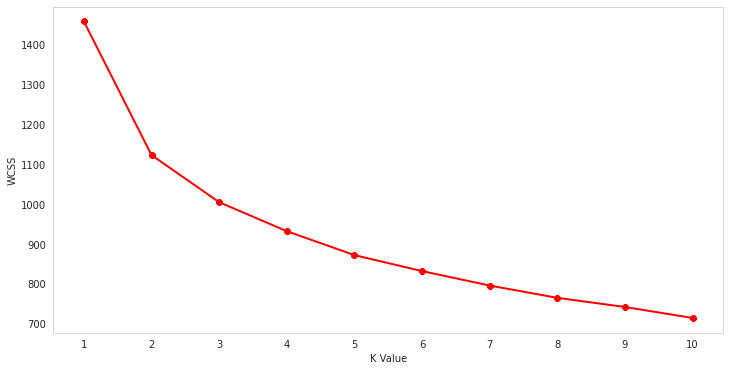

In [ ]:
from sklearn.preprocessing import StandardScaler # data normalization
from sklearn.cluster import KMeans # K-means algorithm

wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(campaign_data_enc[numerical_features].drop(columns=['Kidhome','Teenhome']))
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

In [ ]:
numerical_features

['Income',
 'Kidhome',
 'Teenhome',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'Age',
 'Childs',
 'Fidelity',
 'AcceptedCmp']

In [ ]:
clusters = 3
model = KMeans(init = 'k-means++', 
               n_clusters = clusters, 
               n_init = 12)
model.fit(campaign_data_enc[numerical_features])

labels = model.labels_

In [ ]:
campaign_data_enc['cluster_num'] = labels
campaign_data_enc.groupby('cluster_num').mean()


,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Childs,Fidelity,AcceptedCmp,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,AgeGroup_GenZ,AgeGroup_GenY,AgeGroup_GenX,AgeGroup_BabyBoom,AgeGroup_Gen_Silent
cluster_num,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.07,0.28,0.53,0.50,0.13,0.04,0.04,0.04,0.03,0.08,0.21,0.14,0.05,0.37,0.30,0.06,0.07,0.01,0.02,0.01,0.01,0.09,0.57,0.54,0.46,0.04,0.07,0.01,0.47,0.19,0.26,0.11,0.38,0.18,0.28,0.04,0.00,0.00,0.33,0.64,0.04
1,0.11,0.02,0.16,0.50,0.41,0.30,0.22,0.33,0.23,0.21,0.12,0.21,0.19,0.67,0.18,0.08,0.12,0.19,0.16,0.03,0.01,0.23,0.51,0.12,0.52,0.15,0.09,0.00,0.53,0.15,0.23,0.11,0.37,0.22,0.25,0.05,0.00,0.16,0.30,0.46,0.08
2,0.05,0.41,0.00,0.49,0.03,0.04,0.02,0.04,0.03,0.06,0.13,0.09,0.03,0.25,0.34,0.09,0.01,0.00,0.00,0.00,0.01,0.12,0.34,0.27,0.48,0.03,0.12,0.08,0.51,0.15,0.14,0.08,0.41,0.25,0.24,0.01,0.01,0.35,0.51,0.12,0.02
